In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn  as sns 

In [2]:
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,recall_score,RocCurveDisplay,confusion_matrix,roc_auc_score
from lightgbm import LGBMClassifier,LGBMRegressor

In [3]:
HepatitisC_all = pd.read_csv(f"C:\\Users\\김현종\\Desktop\\HCC Project\\DATA\\CHC_kks_0313.csv")
HepatitisC_all.fillna(-1, inplace=True)
HepatitisC_all.head()  # .head() -> 처음 5개의 data만 보여주는 메소드

,no,Site,ID,name,Age,Gender,DM,Fatty_liver,cirrhosis,LSM_ini,...,Albumin48,LSM_FU48,APR-48,FIB448,AMAP48,MPAGEB48,HCC,HCC_time,Death,FU_time
0,2435.0,5,950313630,김기현,48.0,0,0.0,0.0,2.0,28.4,...,4.0,-1.0,1.666667,9.849371,59.531350,12.0,1,366.0,0,743.0
1,-1.0,10,1263102,오종섭,79.0,1,0.0,0.0,1.0,-1.0,...,4.0,-1.0,0.778146,5.242479,70.746189,14.0,1,370.0,0,1943.0
2,2173.0,5,140236064,박영미,75.0,1,0.0,0.0,1.0,-1.0,...,4.6,-1.0,0.440252,3.154556,54.780730,14.0,1,371.0,0,1953.0
3,-1.0,10,1671998,서숙경,82.0,1,0.0,0.0,1.0,-1.0,...,3.1,-1.0,1.772152,13.700567,77.444515,18.0,1,373.0,0,422.0
4,2102.0,5,50649314,이영임,80.0,1,1.0,0.0,1.0,-1.0,...,3.5,-1.0,0.228758,1.852941,59.618170,15.0,1,376.0,0,532.0


In [4]:
attr_all = HepatitisC_all.columns
print(attr_all)
HepatitisC_all = HepatitisC_all.iloc[np.random.permutation(len(HepatitisC_all))]

Index(['no', 'Site', 'ID', 'name', 'Age', 'Gender', 'DM', 'Fatty_liver',
       'cirrhosis', 'LSM_ini', 'Platelet0', 'AST0', 'ALT0', 'Bilirubin0',
       'Albumin0', 'APRI0', 'FIB40', 'AMAP0', 'MPAGEB0', 'age48', 'Platelet48',
       'AST48', 'ALT48', 'Bilirubin48', 'Albumin48', 'LSM_FU48', 'APR-48',
       'FIB448', 'AMAP48', 'MPAGEB48', 'HCC', 'HCC_time', 'Death', 'FU_time'],
      dtype='object')


In [5]:
### Basic blood test values ###
# attr_pool = ['HCC','Age','Platelet0', 'AST0', 'ALT0', 'Bilirubin0', 'Albumin0', 'Platelet48', 'AST48', 'ALT48', 'Bilirubin48', 'Albumin48']

### Calculated values ### -> This is better when the number of samples are small
attr_pool = ['HCC', 'Platelet0', 'APRI0', 'FIB40', 'AMAP0', 'Platelet48', 'APR-48', 'FIB448', 'AMAP48']

attr = attr_pool

label = 'HCC'

### Read only selected attributes
HepatitisC = HepatitisC_all
for at in attr_all:
    
    if not at in attr_pool:
        # print(at)
        HepatitisC = HepatitisC.drop(at,axis=1)           


In [6]:
HepatitisC = HepatitisC.astype(float)
print(HepatitisC)
### -1: originally it is an empty space in excel-> NaN

      Platelet0     APRI0     FIB40     AMAP0  Platelet48    APR-48    FIB448  \
1203      148.0  1.824324  3.209424  45.21015       135.0 -1.000000 -1.000000   
1398      206.0  0.533981  3.088360  50.23851       188.0  0.252660  1.397160   
639       174.0  0.344828  1.466791  50.01286       222.0 -1.000000 -1.000000   
1619      151.0  0.447020  3.486755  74.68943       197.0  0.596447  5.960171   
958       162.0  0.679012  2.207607  49.14910       119.0  0.441176  3.181369   
...         ...       ...       ...       ...         ...       ...       ...   
500       154.0  0.422078  2.219343  60.62761       180.0  0.263889  2.059396   
1728       79.0  1.518987  7.116779  60.28928        95.0  0.552632  4.489989   
1608      121.0  0.681818  3.227292  62.44134       254.0  0.314961  1.838867   
2794      240.0  0.145833  1.134317  39.54351       215.0 -1.000000 -1.000000   
346       129.0  1.162791  5.746659  53.44622        92.0  0.788043  5.043478   

        AMAP48  HCC  
1203 

In [7]:
### Delete rows if containing missing values

columns = HepatitisC.columns
del_rows = []
for irow in range(len(HepatitisC)):
    
    missing_counts = 0
    for col in columns:
        if HepatitisC[col][irow] <0:
            missing_counts += 1
        
    if missing_counts>0:
        del_rows.append(irow)
        
del_rows = np.array(del_rows)        

HepatitisC = HepatitisC.drop(del_rows, axis = 0)

In [8]:
for at in attr_pool:
    
    if not at in attr:
        # print(at)
        HepatitisC = HepatitisC.drop(at,axis=1)

In [9]:
HepatitisC.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2023 entries, 1398 to 346
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Platelet0   2023 non-null   float64
 1   APRI0       2023 non-null   float64
 2   FIB40       2023 non-null   float64
 3   AMAP0       2023 non-null   float64
 4   Platelet48  2023 non-null   float64
 5   APR-48      2023 non-null   float64
 6   FIB448      2023 non-null   float64
 7   AMAP48      2023 non-null   float64
 8   HCC         2023 non-null   float64
dtypes: float64(9)
memory usage: 158.0 KB


In [10]:
HepatitisC.HCC.value_counts()

HCC
0.0    1893
1.0     130
Name: count, dtype: int64

In [11]:
HepatitisC

,Platelet0,APRI0,FIB40,AMAP0,Platelet48,APR-48,FIB448,AMAP48,HCC
1398,206.0,0.533981,3.088360,50.23851,188.0,0.252660,1.397160,52.30124,0.0
1619,151.0,0.447020,3.486755,74.68943,197.0,0.596447,5.960171,64.40380,0.0
958,162.0,0.679012,2.207607,49.14910,119.0,0.441176,3.181369,51.04054,0.0
2226,212.0,0.318396,1.651737,45.17278,242.0,0.247934,1.462810,43.16393,0.0
2259,112.0,5.000000,9.661876,59.34312,151.0,0.480132,2.822591,55.35877,0.0
...,...,...,...,...,...,...,...,...,...
1765,179.0,0.991620,3.188720,52.44765,156.0,0.352564,2.462669,53.99063,0.0
500,154.0,0.422078,2.219343,60.62761,180.0,0.263889,2.059396,57.79094,0.0
1728,79.0,1.518987,7.116779,60.28928,95.0,0.552632,4.489989,58.62909,0.0
1608,121.0,0.681818,3.227292,62.44134,254.0,0.314961,1.838867,53.11370,0.0


## Data split

In [12]:
X = HepatitisC.drop('HCC',axis=1)
y = HepatitisC['HCC']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.7,random_state=80) #80

In [13]:
y_train.value_counts()

HCC
0.0    1319
1.0      97
Name: count, dtype: int64

In [14]:
y_test.value_counts()

HCC
0.0    574
1.0     33
Name: count, dtype: int64

# Test with ML methods

## 1. Gradient Boosting (LGBM)

### Classifier->AUROC, Regressor->confusion matrix with different threshold 

In [15]:
# DART: Dropouts meet Additive Regression Trees
lgbm_clf = LGBMClassifier(boosting_type = 'dart', num_leaves = 31, max_depth=-1, learning_rate=0.01, n_estimators=500)
lgbm_clf.fit(X_train,y_train)

[LightGBM] [Info] Number of positive: 97, number of negative: 1319
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2035
[LightGBM] [Info] Number of data points in the train set: 1416, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.068503 -> initscore=-2.609918
[LightGBM] [Info] Start training from score -2.609918


LGBMClassifier(boosting_type='dart', learning_rate=0.01, n_estimators=500)

0.942339373970346
[0.99303136 0.06060606]


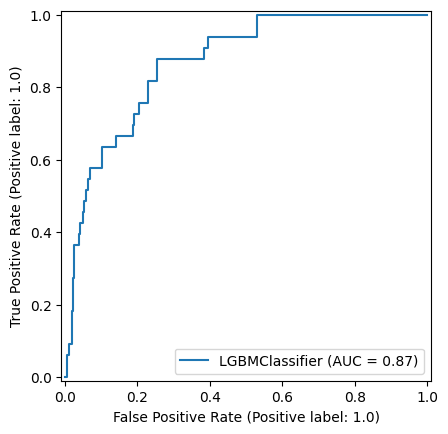

In [16]:
RocCurveDisplay.from_estimator(lgbm_clf, X_test, y_test)
# y_test: LABEL, y_test_pred: Prediction of classifier model
y_test_pred = lgbm_clf.predict(X_test)

print(accuracy_score(y_test,y_test_pred))
print(recall_score(y_test,y_test_pred,average=None))

In [17]:
lgbm_reg = LGBMRegressor(boosting_type = 'dart', num_leaves = 31, max_depth=-1, learning_rate=0.01, n_estimators=500)
lgbm_reg.fit(X_train,y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2035
[LightGBM] [Info] Number of data points in the train set: 1416, number of used features: 8
[LightGBM] [Info] Start training from score 0.068503
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


LGBMRegressor(boosting_type='dart', learning_rate=0.01, n_estimators=500)

### Save test sets and results to CSV

In [18]:
### Due to random samples, indices are shuffled-> reorganize sample orders and run the prediction -> save to csv
attr_x = X_test.columns
row_num = y_test.index  # 환자 번호 (CSV 파일에서 no.)
Xt = np.moveaxis(np.array(X_test.values.tolist()),0,-1)  # X_test.values.tolist() --> 645명의 환자에 대한 8 attributes에 따른 data를 list로 저장
# Xt.shape: (8, 645)
for ii in range(Xt.shape[0]):
    if ii == 0:
        x_test_re = pd.DataFrame({str(attr_x[ii]):Xt[ii]})
    else:
        tmp = pd.DataFrame({str(attr_x[ii]):Xt[ii]})
        x_test_re = x_test_re.join(tmp)
# x_test_re: 재배열된 X_test

# [HCC, name, ID] DataFrame을 생성한다
gt =  pd.DataFrame({'HCC':np.array(y_test.values.tolist())})
name = pd.DataFrame({'Name':np.array(HepatitisC_all['name'][row_num].values.tolist())})
ID = pd.DataFrame({'ID':np.array(HepatitisC_all['ID'][row_num].values.tolist()).astype(np.uint64)})

In [19]:
y_test_pred = lgbm_reg.predict(x_test_re)
# np.maximum(A, B, C, ...): A, B, C, ...를 element-wise하게 비교해서 최대값 반환
y_test_pred_GB = np.maximum(y_test_pred,0)  # y_test_pred와 0을 비교한 최대값 --> 0보다 작은 값은 모두 0으로 반환 (ReLU와 비슷한 효과)

pred = pd.DataFrame({'Prediction':np.array(y_test_pred_GB)})
results = ID.join(name)
results = results.join(x_test_re)
results = results.join(gt)
results = results.join(pred)
print(results)

# 결과를 CSV/EXCEL 파일로 저장
# results.to_csv('Results_Gradient_Boosting.csv', index=False)
# results.to_excel('Results_Gradient_Boosting.xlsx', index=False)

            ID Name  Platelet0     APRI0      FIB40     AMAP0  Platelet48  \
0      2417802  정*자      225.0  0.333333   1.646386  47.56578       287.0   
1      2761715  정○산      134.0  0.373134   1.917505  56.77456       153.0   
2      3293061  박*영      252.0  2.569444   3.711226  43.17929       339.0   
3      7092698  이*남      188.0  0.305851   1.487541  43.81994       223.0   
4    110579926  배진학      180.0  0.375000   1.928158  45.35732       202.0   
..         ...  ...        ...       ...        ...       ...         ...   
602    1404547  노정숙      128.0  1.093750   6.187184  51.57624       146.0   
603    2977842  곽호영       57.0  5.789474  12.224198  66.48125       104.0   
604  110303516  김명구      279.0  0.250896   1.136566  61.85134       330.0   
605  130479721  박희권      267.0  0.243446   1.218286  46.69491       331.0   
606  130611000  정숙이      158.0  1.060127   5.482081  48.51555       174.0   

       APR-48    FIB448    AMAP48  HCC  Prediction  
0    0.278746  1.53819

In [20]:
thresholds = np.linspace(0.01,0.13,10)
print(thresholds)
for th in thresholds:
    y_pred = np.zeros((y_test_pred_GB.shape),dtype = float)
    y_pred[y_test_pred>th] = 1
    TP = [k for k in range(len(gt.values)) if (gt.values[k] == 1 and y_pred[k] ==1)]
    FP = [k for k in range(len(gt.values)) if (gt.values[k] == 0 and y_pred[k] ==1)]
    TN = [k for k in range(len(gt.values)) if (gt.values[k] == 0 and y_pred[k] ==0)]
    FN = [k for k in range(len(gt.values)) if (gt.values[k] == 1 and y_pred[k] ==0)]
    print("Confusion matrix: threshold - %.3f"%th)
    print("T    |      Prediction      | ")
    print("R    |     N     |    P     | ")
    print("U  0 |    %.2f   |   %.2f   | "%(float(len(TN))/float(len(FP)+len(TN)),float(len(FP))/float(len(FP)+len(TN))))
    print("E  1 |    %.2f   |   %.2f   | "%(float(len(FN))/float(len(TP)+len(FN)),float(len(TP))/float(len(TP)+len(FN))))
    
    # print(confusion_matrix(y_test,y_pred,normalize='true'))

[0.01       0.02333333 0.03666667 0.05       0.06333333 0.07666667
 0.09       0.10333333 0.11666667 0.13      ]
Confusion matrix: threshold - 0.010
T    |      Prediction      | 
R    |     N     |    P     | 
U  0 |    0.48   |   0.52   | 
E  1 |    0.09   |   0.91   | 
Confusion matrix: threshold - 0.023
T    |      Prediction      | 
R    |     N     |    P     | 
U  0 |    0.61   |   0.39   | 
E  1 |    0.09   |   0.91   | 
Confusion matrix: threshold - 0.037
T    |      Prediction      | 
R    |     N     |    P     | 
U  0 |    0.68   |   0.32   | 
E  1 |    0.09   |   0.91   | 
Confusion matrix: threshold - 0.050
T    |      Prediction      | 
R    |     N     |    P     | 
U  0 |    0.74   |   0.26   | 
E  1 |    0.18   |   0.82   | 
Confusion matrix: threshold - 0.063
T    |      Prediction      | 
R    |     N     |    P     | 
U  0 |    0.79   |   0.21   | 
E  1 |    0.21   |   0.79   | 
Confusion matrix: threshold - 0.077
T    |      Prediction      | 
R    |     N     |  

In [21]:
Feature_importance = pd.DataFrame({'Feature':X_train.columns,'Importance':lgbm_reg.feature_importances_})
Feature_importance = Feature_importance.sort_values(by='Importance',ascending=False)
Feature_importance = Feature_importance.set_index('Feature')

Feature_importance

,Importance
Feature,
AMAP0,3237
APR-48,2129
Platelet0,2079
APRI0,2045
FIB40,1803
AMAP48,1402
Platelet48,1305
FIB448,996


## Decision Tree

In [22]:
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

dtree_clf = DecisionTreeClassifier()
parameters = {'max_depth':[3,5,7], 'min_samples_leaf':[5,10,15,20]}  # 이 parameter들을 dtree_clf에 입력해서 그 중의 최적의 parameter를 찾는다

dt_clf_GS = GridSearchCV(dtree_clf, parameters, cv=5)  # cv: Cross-Validation
dt_clf_GS.fit(X_train, y_train)
# dt_clf_GS.best_params_: 최적의 parameter 반환
# dt_clf_GS.best_score_: 가장 높은 성능 반환
# dt_clf_GS.best_estimator: 최적의 parameter로 RE-Trained된 estimator 모델
# dt_clf_GS.classes_: 무슨 classes를 반환하는가?

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [3, 5, 7],
                         'min_samples_leaf': [5, 10, 15, 20]})

In [23]:
# dt_clf_GS.predict_proba(X: array-like) -> 무슨 확률을 예측?
print('Train AUC-ROC score is', roc_auc_score(y_train, dt_clf_GS.predict_proba(X_train)[:, 1]))
print('Test AUC-ROC score is', roc_auc_score(y_test, dt_clf_GS.predict_proba(X_test)[:, 1]))

Train AUC-ROC score is 0.8377988635564274
Test AUC-ROC score is 0.8342836025762855


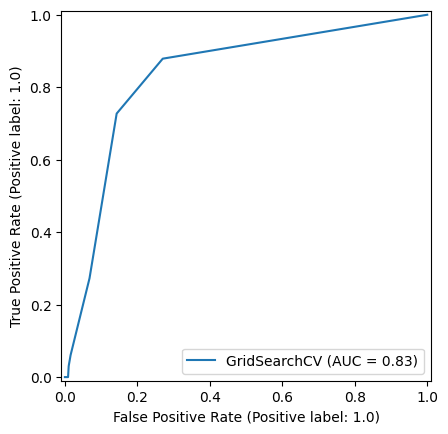

In [24]:
RocCurveDisplay.from_estimator(dt_clf_GS,X_test,y_test)  # .best_estimator_ 메소드 없이도 자동으로 최적의 parameter로 재학습한 estimator를 사용하는가?

In [25]:
dtree_reg = DecisionTreeRegressor()
dt_reg_GS = GridSearchCV(dtree_reg, parameters, cv=5)
dt_reg_GS.fit(X_train, y_train)

y_test_pred = dt_reg_GS.predict(x_test_re)
y_test_pred_DT = np.maximum(y_test_pred, 0)

pred = pd.DataFrame({'Predition':np.array(y_test_pred_DT)})
results = ID.join(name)
results = results.join(x_test_re)
results = results.join(gt)
results = results.join(pred)

# 결과를 CSV/EXCEL 파일로 저장
# results.to_csv('Results_Decision_Tree.csv', index=False)
# results.to_excel('Results_Decision_Tree.xlsx', index=False)

thresholds = np.linspace(0.03,0.07,10)
print(thresholds)
for th in thresholds:
    y_pred = np.zeros((y_test_pred.shape),dtype = float)  # y_pred: 크기 (645,)의 ndarray
    y_pred[y_test_pred>th] = 1  # Prediction이 threshold보다 큰 경우에만 1로 예측 (threshold보다 낮으면 0으로 예측)
    TP = [k for k in range(len(gt.values)) if (gt.values[k] == 1 and y_pred[k] ==1)]
    FP = [k for k in range(len(gt.values)) if (gt.values[k] == 0 and y_pred[k] ==1)]
    TN = [k for k in range(len(gt.values)) if (gt.values[k] == 0 and y_pred[k] ==0)]
    FN = [k for k in range(len(gt.values)) if (gt.values[k] == 1 and y_pred[k] ==0)]
    print("Confusion matrix: threshold - %.3f"%th)
    print("T    |      Prediction      | ")
    print("R    |     N     |    P     | ")
    print("U  0 |    %.2f   |   %.2f   | "%(float(len(TN))/float(len(FP)+len(TN)),float(len(FP))/float(len(FP)+len(TN))))
    print("E  1 |    %.2f   |   %.2f   | "%(float(len(FN))/float(len(TP)+len(FN)),float(len(TP))/float(len(TP)+len(FN))))
    
    # print(confusion_matrix(y_test,y_pred,normalize='true'))

[0.03       0.03444444 0.03888889 0.04333333 0.04777778 0.05222222
 0.05666667 0.06111111 0.06555556 0.07      ]
Confusion matrix: threshold - 0.030
T    |      Prediction      | 
R    |     N     |    P     | 
U  0 |    0.73   |   0.27   | 
E  1 |    0.12   |   0.88   | 
Confusion matrix: threshold - 0.034
T    |      Prediction      | 
R    |     N     |    P     | 
U  0 |    0.73   |   0.27   | 
E  1 |    0.12   |   0.88   | 
Confusion matrix: threshold - 0.039
T    |      Prediction      | 
R    |     N     |    P     | 
U  0 |    0.73   |   0.27   | 
E  1 |    0.12   |   0.88   | 
Confusion matrix: threshold - 0.043
T    |      Prediction      | 
R    |     N     |    P     | 
U  0 |    0.73   |   0.27   | 
E  1 |    0.12   |   0.88   | 
Confusion matrix: threshold - 0.048
T    |      Prediction      | 
R    |     N     |    P     | 
U  0 |    0.73   |   0.27   | 
E  1 |    0.12   |   0.88   | 
Confusion matrix: threshold - 0.052
T    |      Prediction      | 
R    |     N     |  

## Random Forest

In [26]:
forest_clf = RandomForestClassifier()
parameters = {'max_depth':[3,5,7,9], 'min_samples_leaf':[5,10,15,20]}

f_clf_GS = GridSearchCV(forest_clf, parameters, cv=3)
f_clf_GS.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [3, 5, 7, 9],
                         'min_samples_leaf': [5, 10, 15, 20]})

In [27]:
print('Train AUC-ROC score is', roc_auc_score(y_train, f_clf_GS.predict_proba(X_train)[:, 1]))
print('Test AUC-ROC score is', roc_auc_score(y_test, f_clf_GS.predict_proba(X_test)[:, 1]))

Train AUC-ROC score is 0.8777463401671056
Test AUC-ROC score is 0.8718720304086158


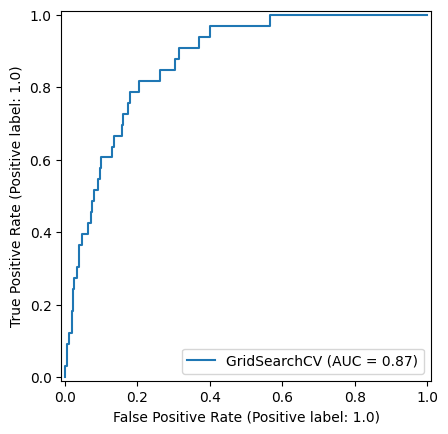

In [28]:
RocCurveDisplay.from_estimator(f_clf_GS,X_test,y_test)
y_test_pred_RF = f_clf_GS.predict_proba(x_test_re)[:, 1]

pred = pd.DataFrame({'Predition':np.array(y_test_pred_RF)})
results = ID.join(name)
results = results.join(x_test_re)
results = results.join(gt)
results = results.join(pred)

# 결과를 CSV/EXCEL 파일로 저장
# results.to_csv('Results_Random_Forest.csv', index=False)
# results.to_excel('Results_Random_Forest.xlsx', index=False)

In [29]:
thresholds = np.linspace(0.06,0.09,10)
print(thresholds)
for th in thresholds:
    y_pred = np.zeros((y_test_pred_RF.shape),dtype = float)
    y_pred[y_test_pred_RF>th] = 1
    TP = [k for k in range(len(gt.values)) if (gt.values[k] == 1 and y_pred[k] ==1)]
    FP = [k for k in range(len(gt.values)) if (gt.values[k] == 0 and y_pred[k] ==1)]
    TN = [k for k in range(len(gt.values)) if (gt.values[k] == 0 and y_pred[k] ==0)]
    FN = [k for k in range(len(gt.values)) if (gt.values[k] == 1 and y_pred[k] ==0)]
    print("Confusion matrix: threshold - %.3f"%th)
    print("T    |      Prediction      | ")
    print("R    |     N     |    P     | ")
    print("U  0 |    %.3f   |   %.3f   | "%(float(len(TN))/float(len(FP)+len(TN)),float(len(FP))/float(len(FP)+len(TN))))
    print("E  1 |    %.3f   |   %.3f   | "%(float(len(FN))/float(len(TP)+len(FN)),float(len(TP))/float(len(TP)+len(FN))))
    
    # print(confusion_matrix(y_test,y_pred,normalize='true'))

[0.06       0.06333333 0.06666667 0.07       0.07333333 0.07666667
 0.08       0.08333333 0.08666667 0.09      ]
Confusion matrix: threshold - 0.060
T    |      Prediction      | 
R    |     N     |    P     | 
U  0 |    0.732   |   0.268   | 
E  1 |    0.152   |   0.848   | 
Confusion matrix: threshold - 0.063
T    |      Prediction      | 
R    |     N     |    P     | 
U  0 |    0.751   |   0.249   | 
E  1 |    0.182   |   0.818   | 
Confusion matrix: threshold - 0.067
T    |      Prediction      | 
R    |     N     |    P     | 
U  0 |    0.756   |   0.244   | 
E  1 |    0.182   |   0.818   | 
Confusion matrix: threshold - 0.070
T    |      Prediction      | 
R    |     N     |    P     | 
U  0 |    0.775   |   0.225   | 
E  1 |    0.182   |   0.818   | 
Confusion matrix: threshold - 0.073
T    |      Prediction      | 
R    |     N     |    P     | 
U  0 |    0.782   |   0.218   | 
E  1 |    0.182   |   0.818   | 
Confusion matrix: threshold - 0.077
T    |      Prediction      | 


## AUROC with 95% confidence interval

In [31]:
import sklearn.metrics
import numpy as np
import matplotlib.axes
import matplotlib.figure
import matplotlib.pyplot as plt
import pandas as pd

import calc_froc

In [32]:
from calc_froc import plot_roc_with_ci,plot_roc_with_ci

In [33]:
from typing import List, Tuple, Union, Any

In [34]:
def roc_with_ci(
    preds: np.array,
    labels: np.array,
    ci: float = 95,
    nbst: int = 1000,
    seed: Union[int, np.random.Generator] = None,
) -> dict:
    fprs, tprs, ths = sklearn.metrics.roc_curve(labels, preds)
    auc = sklearn.metrics.auc(fprs, tprs)

    # bootstrap to get confidence interval
    tpr_bst_list = []
    auc_bst_list = []
    rng = np.random.default_rng(seed)
    for i in range(nbst):
        # sampling with replacement
        ind = rng.integers(0, len(labels), len(labels))
        label_bst = labels[ind]
        pred_bst = preds[ind]

        # calculate ROC for each bootstrap
        fpr_bst, tpr_bst, _ = sklearn.metrics.roc_curve(label_bst, pred_bst)

        # resample the roc for each fprs
        tpr_sample = np.interp(fprs, fpr_bst, tpr_bst)
        tpr_bst_list.append(tpr_sample)
        auc_bst_list.append(sklearn.metrics.auc(fpr_bst, tpr_bst))

    tpr_bst_list = np.array(tpr_bst_list)
    tprs_ci = np.percentile(tpr_bst_list, [(100 - ci) / 2, 100 - (100 - ci) / 2], axis=0)
    auc_ci = np.percentile(auc_bst_list, [(100 - ci) / 2, 100 - (100 - ci) / 2])

    return {
        'fprs': fprs,
        'tprs': tprs,
        'ths': ths,
        'tprs_ci': tprs_ci,
        'auc': auc,
        'auc_ci': auc_ci
    }

def roc_with_ci_draw(pred,gt,save_fig_name):
    results = roc_with_ci(np.array(pred),np.array(gt))

    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    linestyle_cycle = ['-', '--']
    fig, ax = plt.subplots(figsize=[6, 4], dpi=300)
    
    color = colors[0]
    linestyle = linestyle_cycle[0]
    
    ax = plot_roc_with_ci(
        ax, results['fprs'], results['tprs'], results['tprs_ci'], color=color, linestyle=linestyle
    )
    
    ax.set_xlabel('False positive')
    ax.set_ylabel('True positive')
    ax.grid(True)
    ax.set_xlim([-0.03, 1])
    ax.set_ylim([-0.03, 1.03])
    ax.legend(['AUC = %.2f $\pm$ 95 %% confidence'%results['auc']],loc=4)
    # plt.savefig(save_fig_name)  # FROC plot 저장
    plt.show()

<>:61: SyntaxWarning: invalid escape sequence '\p'
<>:61: SyntaxWarning: invalid escape sequence '\p'
C:\Users\김현종\AppData\Local\Temp\ipykernel_17292\1492191649.py:61: SyntaxWarning: invalid escape sequence '\p'
  ax.legend(['AUC = %.2f $\pm$ 95 %% confidence'%results['auc']],loc=4)


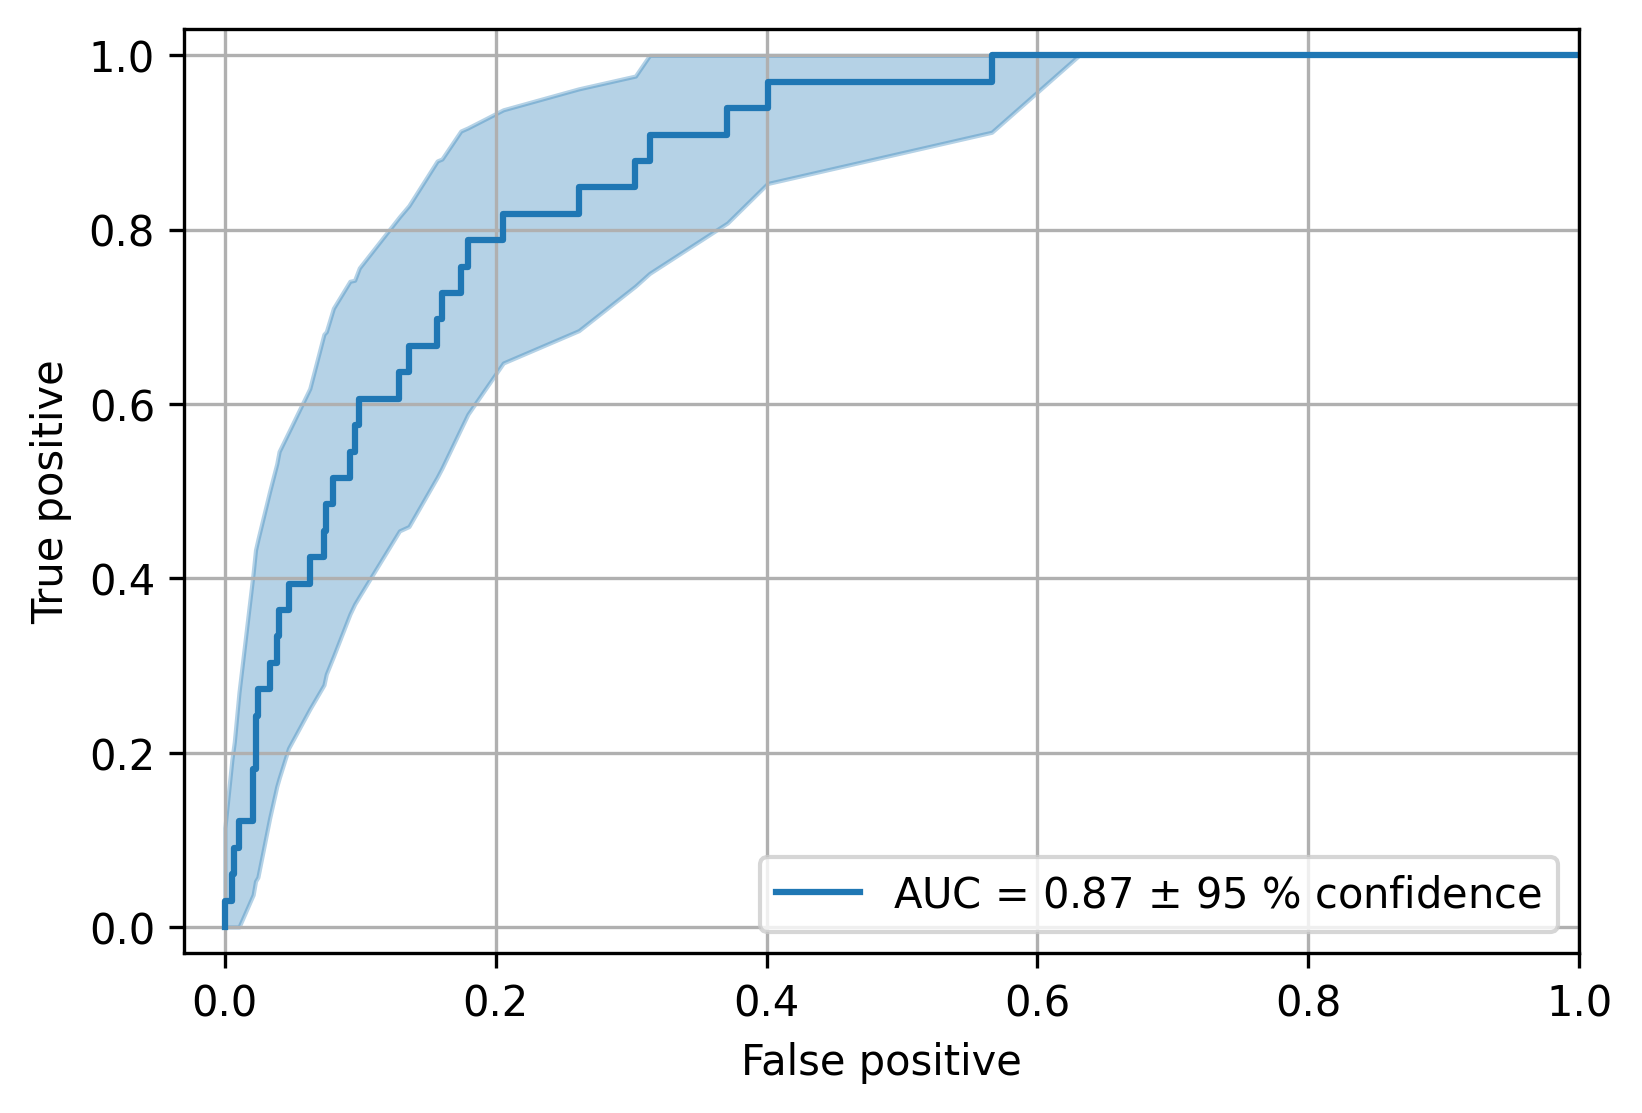

In [35]:
roc_with_ci_draw(y_test_pred_RF,gt,'RandomForest')

In [ ]:
import shap
from shap import summary_plot

/home/user1/바탕화면/yes/envs/test/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf_reg = RandomForestRegressor(n_estimators = 500, random_state=80)
rf_reg.fit(X_train,y_train)

RandomForestRegressor(n_estimators=500, random_state=80)

# 1.1 LGBM Classifier

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


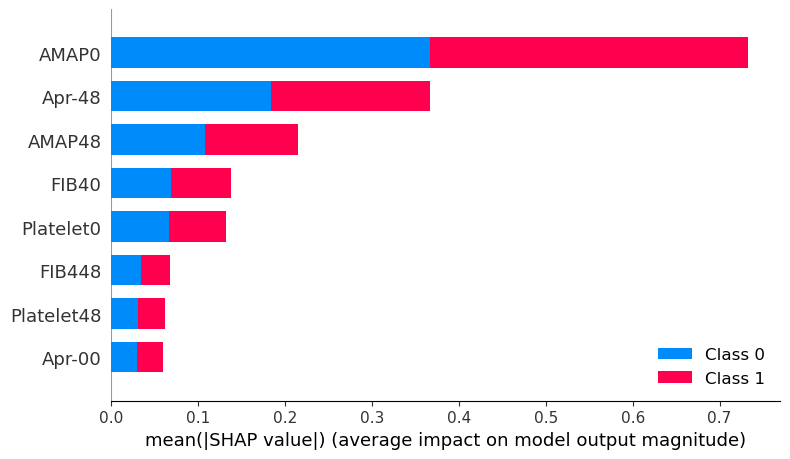

In [ ]:
explainer = shap.TreeExplainer(lgbm_clf)
shap_values = explainer.shap_values(x_test_re)
shap.summary_plot(shap_values, x_test_re)

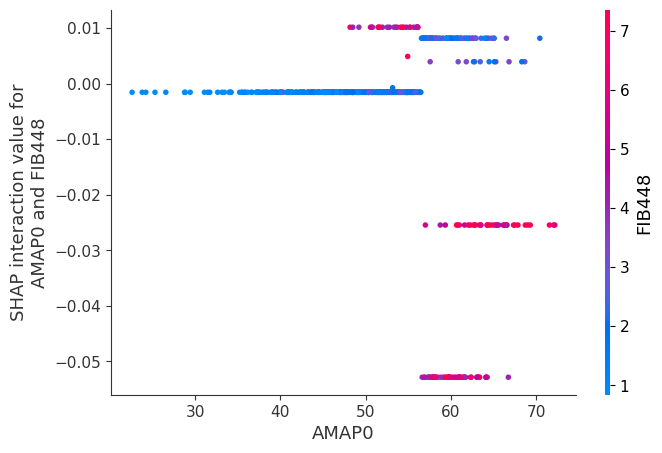

In [ ]:
shap_interaction_values = explainer.shap_interaction_values(x_test_re)
shap.dependence_plot(('AMAP0', 'FIB448'), shap_interaction_values, x_test_re, display_features=x_test_re)

# 1.2 LGBM Regressor

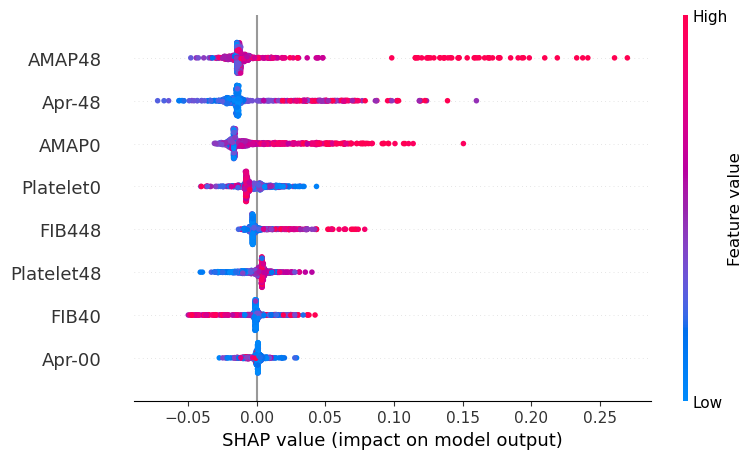

In [ ]:
explainer = shap.TreeExplainer(lgbm_reg)
shap_values = explainer.shap_values(x_test_re)
shap.summary_plot(shap_values, x_test_re)

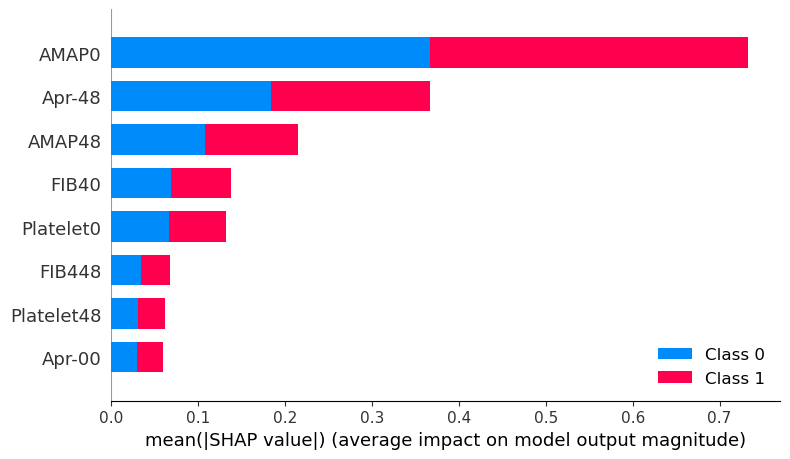

In [ ]:
shap.summary_plot(shap_values, x_test_re, plot_type='bar')

# 2.1 Decision Tree Classifier

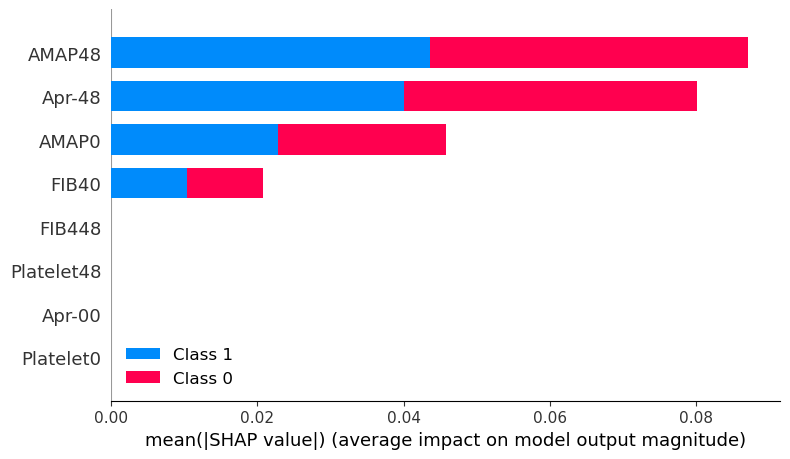

In [ ]:
# Classifier는 bar형태 Histogram밖에 없는 것 같다 (확인 필요)
dt_clf_est = dt_clf_GS.best_estimator_
explainer = shap.TreeExplainer(dt_clf_est)
shap_values = explainer.shap_values(x_test_re)
shap.summary_plot(shap_values, x_test_re)

# 2.2 Decision Tree Regressor

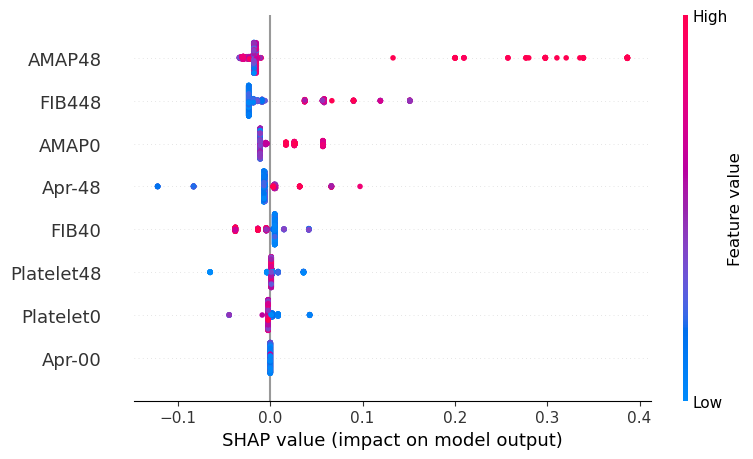

In [ ]:
dt_reg_est = dt_reg_GS.best_estimator_
explainer = shap.TreeExplainer(dt_reg_est)
shap_values = explainer.shap_values(x_test_re)
shap.summary_plot(shap_values, x_test_re)

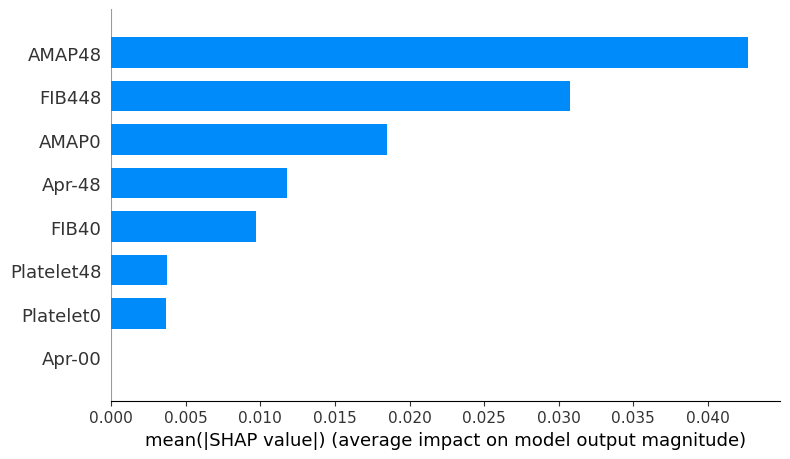

In [ ]:
shap.summary_plot(shap_values, x_test_re, plot_type='bar')
# 얘는 왜 Class 1개밖에 없나??

# 3.1 Random Forest Classifier

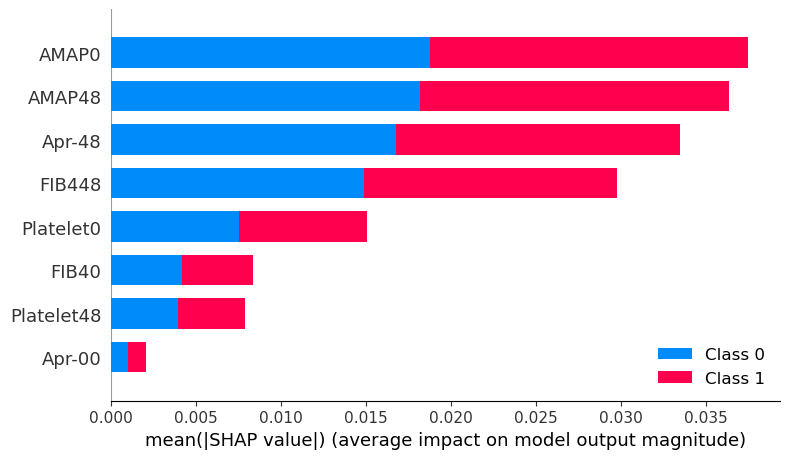

In [ ]:
forest_est = f_clf_GS.best_estimator_
explainer = shap.TreeExplainer(forest_est)
shap_values = explainer.shap_values(x_test_re)
shap.summary_plot(shap_values, x_test_re)

# 3.2 Random Forest Regressor

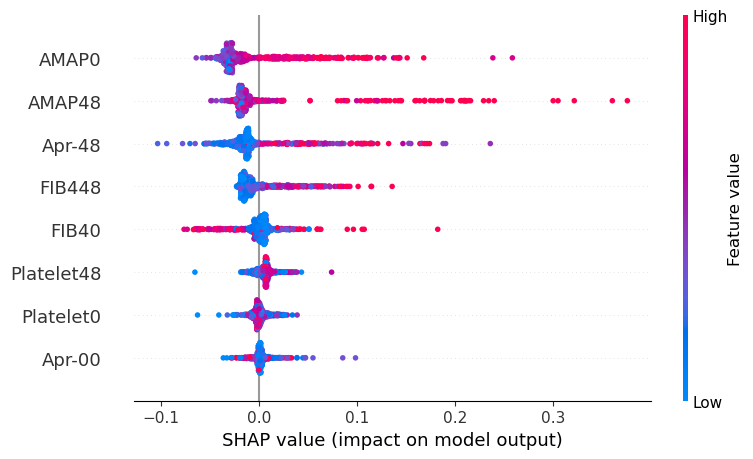

In [ ]:
explainer = shap.TreeExplainer(rf_reg)
shap_values = explainer.shap_values(x_test_re)
shap.summary_plot(shap_values, x_test_re)